# Preface

TFT is a spin-off video game based off the League of Legends world and characters created by Riot. TFT was created with inspiration of Dota 2's auto chess.

In TFT you have 8 participants per match that fight against each other by forming many combinations of different traits and items. TFT is a game about probability (luck and expected values) and economy management. You get gold each round to either roll down for a new set of units to buy or purchase experience to further your exp bar and progress to the next level. Each level allows you to set down another unit and increases the chance that certain rarities/units appear. At the max level (9) you can place up to 9 units and with certain augments/items you are allowed to place extra as well.

Players fight each other by placing a set number of units on a hexagonal board as they wish. These units fight each other automatically when a round starts. The player who defeats their opponent’s whole squad is declared the winner of a round, and when the round is over, all units on both sides are reset to their previous position to get ready for the next round. When you lose a round, you lose points represented by the health of your tactician, not your units. The more opposing pieces alive after a round ends, the greater the damage you’ll take. Players who reach zero health points are knocked out of the match regardless of which round they’re in. The last player with their tactician standing is declared the winner of an autobattler match.

TFT runs off seasons or "sets" in which every 6 months a new set appears with new mechanics and synergies along with a mid-set half way. This set is based off set 7.5 which is the mid-set of set 7. I gathered the data utilizing Riot API end points and some python code :). If you would like to see my web scraping and initial wrangling i've provided that notebook aswell in the directory.

For this analysis we will only focus on the highest tier of ranked matches, the challenger league.


To explain some of the columns: 
* `combination`: column of dictionaries that show synergistic traits each participant has in the current match. Key: traits, Value: # of combined traits.
* `champion`: shows which champions each of the players set, also dictionary format. Key: champion name, Value: items, tier (tier enhance the units stats, it holds a value of 1-3)
* `match_id`: unique ID for ranked match
* `game_version`: patch version for set 7.5
* `game_length`: total game duration in seconds
* `level`: participant level (1-9 sometimes 10 if you have the special augment)
* `last_round`: last round of current participant (round before death)
* `placement`: participant ranking in the game after it finishes (1-8)
* `time_eliminated`: time spent playing per participant in seconds before being eliminated (or wins if first)
* `gold_left`: amount of gold left when a participants gets eliminated (or wins if first)


I have several ideas/questions and a goal in mind with the dataset:
* My goal is to be able to leverage a multiclass classification model in order to predict the ranking (1-8) of a participant at the end of a match
* What correlations exist between the features?
* Engineer more features if possible
* What are the common compositions when a player has 2 units? 4 units? 6 units? 8 or more units?
* How much gold left does a tactician have when reaching certain levels?
* How accuratetly and efficiently can the model predict the placement of a player?
* What is the most impactful composition that determines predicting rank?
* What are the most impactful champions along with their item set ups that determines predicting rank?

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ast
import re
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.style.use('seaborn')
FONT = {'size'   : 14}
plt.rc('font', **FONT)

In [23]:
df = pd.read_csv('TFT_Challenger_NA_Data.csv')

# EDA

In this section I will perform Exploratory Data Analysis. I will come up with meaningful insights and relationships between the features in order to better understand the data. This will be an iterative process - meaning I will come back to it and refine my exploration/findings.


In [24]:
df.head()

,match_id,game_length,game_version,time_eliminated,gold_left,last_round,level,placement,combination,champion
0,NA1_4471233617,2353.634277,Version 12.20.474.8882 (Oct 20 2022/13:06:55) ...,1734.635498,0,30,8,7,"{'Set7_Cavalier': 2, 'Set7_Dragon': 2, 'Set7_D...","{'TFT7_Sejuani': {'items': [], 'tier': 1}, 'TF..."
1,NA1_4471233617,2353.634277,Version 12.20.474.8882 (Oct 20 2022/13:06:55) ...,1732.625000,5,30,8,6,"{'Set7_Bard': 1, 'Set7_Cavalier': 2, 'Set7_Dra...","{'TFT7_Leona': {'items': [], 'tier': 2}, 'TFT7..."
2,NA1_4471233617,2353.634277,Version 12.20.474.8882 (Oct 20 2022/13:06:55) ...,1512.855347,23,26,7,8,"{'Set7_Astral': 5, 'Set7_Bruiser': 2, 'Set7_Ma...",{'TFT7_Vladimir': {'items': ['TFT_Item_ThiefsG...
3,NA1_4471233617,2353.634277,Version 12.20.474.8882 (Oct 20 2022/13:06:55) ...,2345.331299,5,41,9,1,"{'Set7_Bard': 1, 'Set7_Cannoneer': 2, 'Set7_Ev...",{'TFT7_Zyra': {'items': ['TFT_Item_ZekesHerald...
4,NA1_4471233617,2353.634277,Version 12.20.474.8882 (Oct 20 2022/13:06:55) ...,2342.827393,20,41,9,3,"{'Set7_Dragon': 1, 'Set7_Dragonmancer': 8, 'Se...","{'TFT7_Sett': {'items': [], 'tier': 3}, 'TFT7_..."


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69688 entries, 0 to 69687
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   match_id         69688 non-null  object 
 1   game_length      69688 non-null  float64
 2   game_version     69688 non-null  object 
 3   time_eliminated  69688 non-null  float64
 4   gold_left        69688 non-null  int64  
 5   last_round       69688 non-null  int64  
 6   level            69688 non-null  int64  
 7   placement        69688 non-null  int64  
 8   combination      69688 non-null  object 
 9   champion         69688 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 5.3+ MB


In [26]:
df.match_id.nunique()

5144

About 69,688 rows but only 5144 unique matches with 8 participants per match.

In [27]:
df.describe()

,game_length,time_eliminated,gold_left,last_round,level,placement
count,69688.000000,69688.000000,69688.000000,69688.000000,69688.000000,69688.000000
mean,2283.736197,1967.398617,8.139364,32.827990,8.245236,4.500000
std,146.409363,288.523209,14.356458,4.863964,0.676611,2.291304
min,1324.090820,448.749207,0.000000,9.000000,4.000000,1.000000
25%,2184.992188,1759.294434,1.000000,30.000000,8.000000,2.750000
50%,2281.203857,1996.138916,2.000000,33.000000,8.000000,4.500000
75%,2393.726074,2179.017029,9.000000,37.000000,9.000000,6.250000
max,2810.665771,2802.463623,197.000000,47.000000,10.000000,8.000000


Everything looks normal here numerically, no outliers.

Average time a challenger lasts in a match is ~ 1968 seconds (~33 min).

Average challenger ranked match takes ~ 2283 seconds (~38 min).


In [28]:
#function for adding space before capitalized letters

def split_string(string):
    return ''.join([x if x.islower() else f" {x}" for x in string])
#function for histograms

def my_hist_plot(df, x_var, interval, limit=1, figsize=[14,6]):
    
    # setting intervals for bins
    bins = np.arange(df[x_var].min(), df[x_var].quantile(limit)+interval, interval)
    #plot
    df[x_var].hist(bins = bins, grid = False, edgecolor = 'black', figsize = figsize);
    #labeling
    x_var = split_string(x_var)
    #title
    plt.title(f'Distribution of {x_var}{" - Data Excluded: "} {(1-limit):.0%}'.title(), fontsize = 14, weight = 'bold')
    #x label
    plt.xlabel(x_var.title(), fontsize = 12, weight = 'bold')
    #y label
    plt.ylabel('Frequency'.title(), fontsize = 12, weight = 'bold')
    

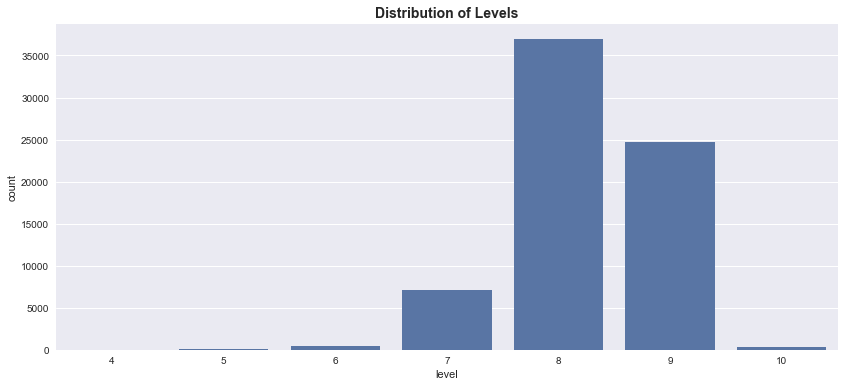

In [29]:
plt.figure(figsize=(14,6))
sns.countplot(data=df, x='level', color=sns.color_palette()[0])
plt.title('Distribution of Levels', fontsize=14, weight='bold');

Distribution of levels for challenger matches show a left skew. This distribution does not need to be transformed as the data makes sense. Challenger players tend to hit level 8 by the time the game ends, hitting level 9 (max) is the next common level to cap out by the end of the game, with 7 being the next common level to end at if you play a reroll composition. Some challengers get the special experience augment which allows them to reach an even higher level of 10.

A reroll composition is basically when the player spends most of his economy on purchasing unit power to increase tier levels for their units instead of overall experience for their tactician.


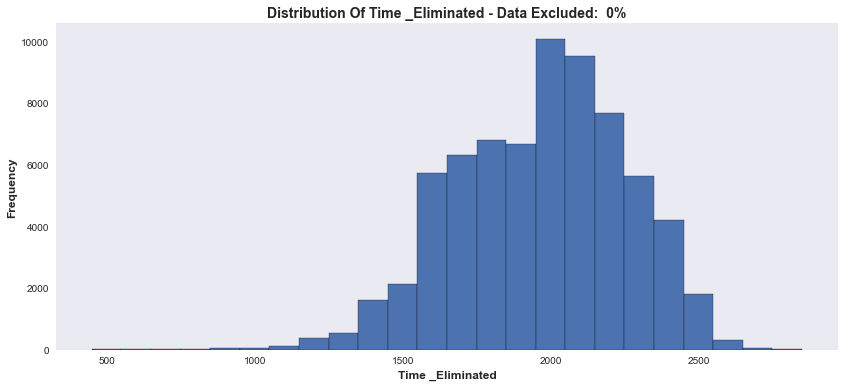

In [30]:
my_hist_plot(df, 'time_eliminated', 100)

Distribution of in game duration (how long a player lasts during a match in seconds) shows a slight left skew with a unimodal distribution. Nothing to pick apart from here, it will be interesting to see the correlation between this and what rank a player finishes by the end of the match. My guess it will be highly correlated.


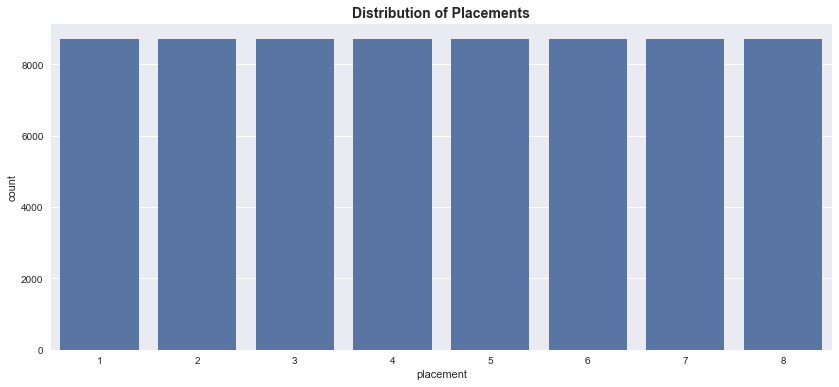

In [31]:
plt.figure(figsize=(14,6))
sns.countplot(data=df, x='placement', color=sns.color_palette()[0])
plt.title('Distribution of Placements', fontsize=14, weight='bold');

This is wonderful, the data is balanced! This will allow the model to properly classify who ranks what without bias.

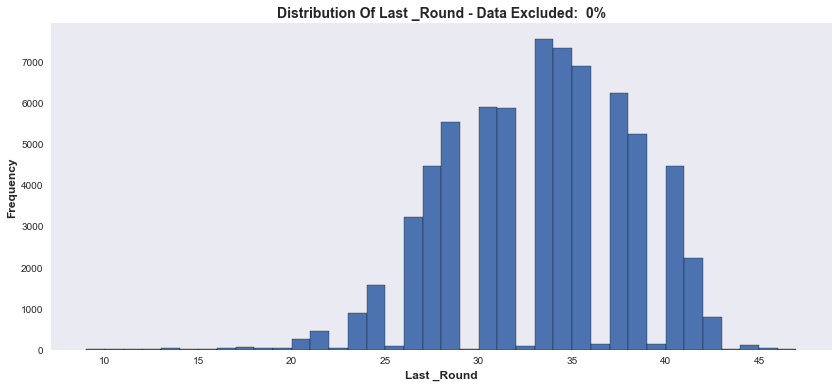

In [32]:
my_hist_plot(df, 'last_round', 1)

Looks oddly similar to the distribution of in game duration, not surprising because these should be directly correlated. The higher round a player finishes the game off the longer the match would be for them.

What correlations exist between the features?


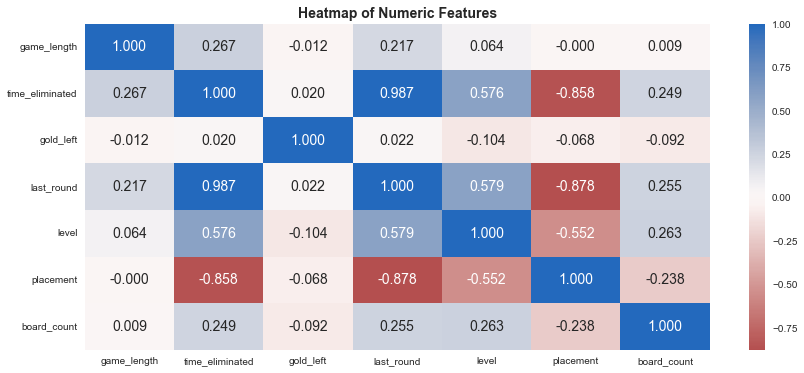

In [55]:
plt.figure(figsize = [14, 6])
corr_matrix = df.corr(method='pearson')
sns_corr_heatmap = sns.heatmap(corr_matrix, annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0)
plt.title("Heatmap of Numeric Features", fontsize=14, weight='bold');

It's important to check for multicollinearity so that it doesn't hurt our classification model due to overfitting. Later on after transforming I will check the VIFs

* And there it is, 0.987 correlation for `last_round` and `time_eliminated`. Interestingly enough is that actual game duration of the entire match isn't highly correlated with anything
* `placement` and `time_eliminated` also have a high negative correlation, this makes sense since ranking is ordered from best to worse (1-8) those that get 8th place tend to be knocked out of the match first thus lower in game time
* `placement` and `last_round` are also negatively correlated which also makes sense by the same logic as above

<Figure size 1008x432 with 0 Axes>

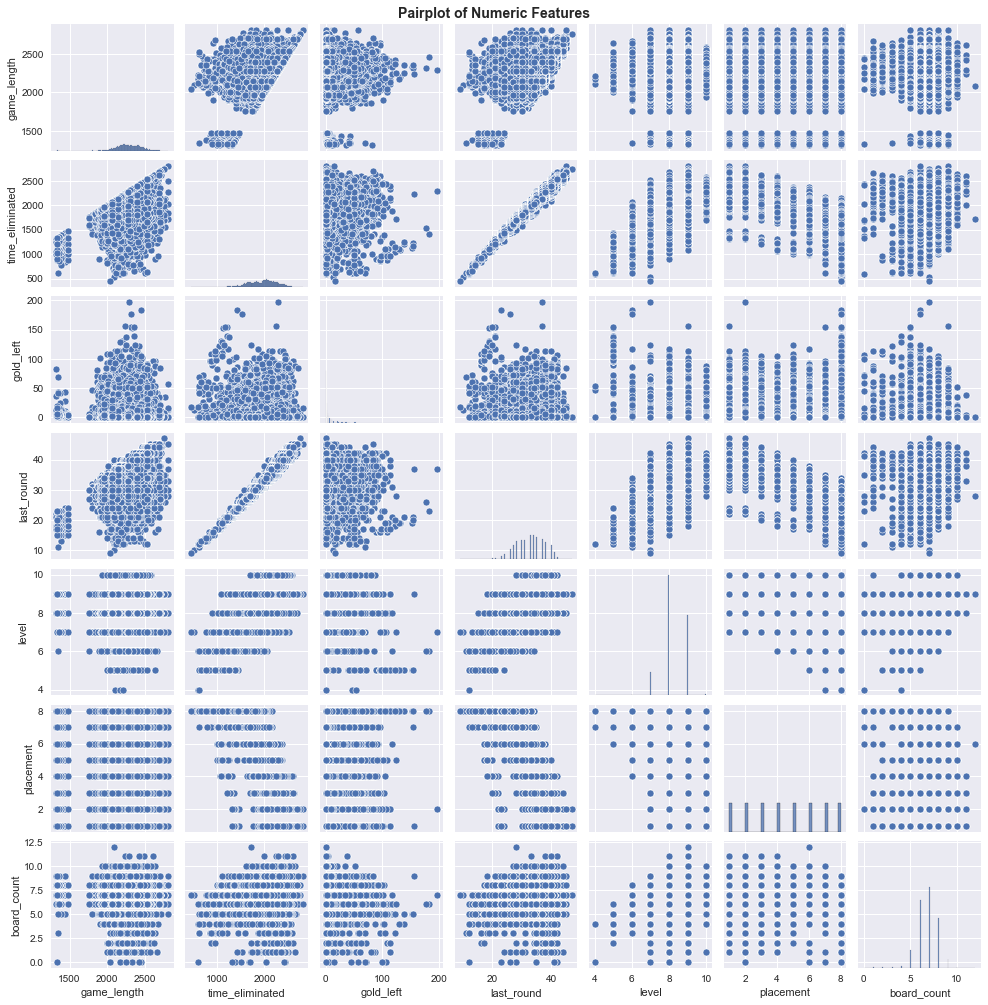

In [54]:
plt.figure(figsize = [14, 6])
sns.pairplot(df, height=2.0)
plt.suptitle('Pairplot of Numeric Features', fontsize=14, weight='bold', y=1.0);

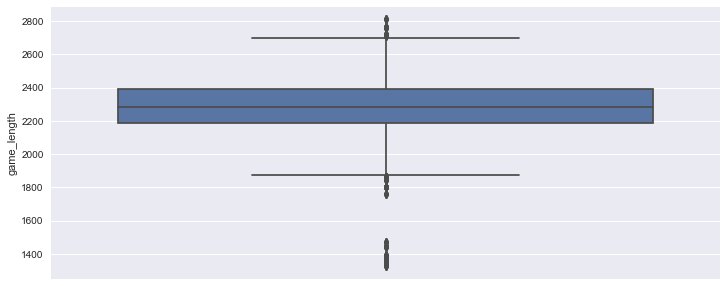

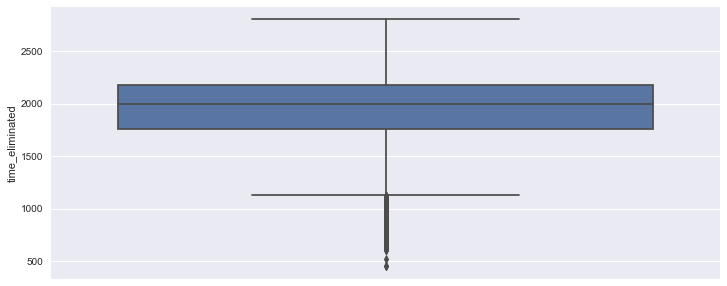

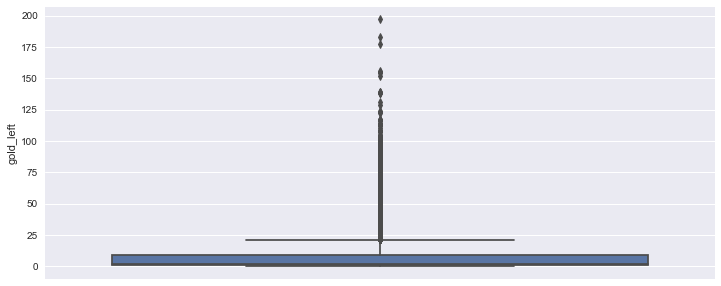

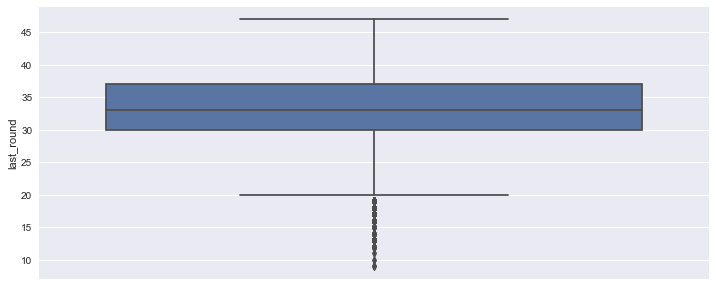

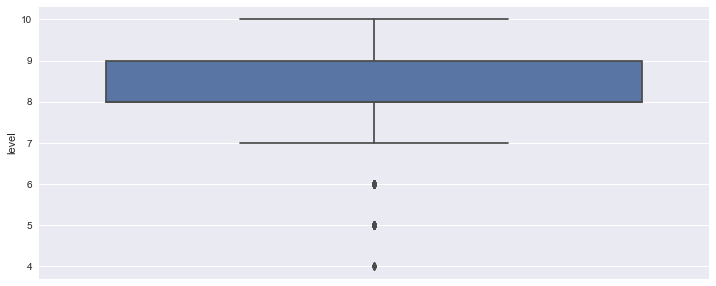

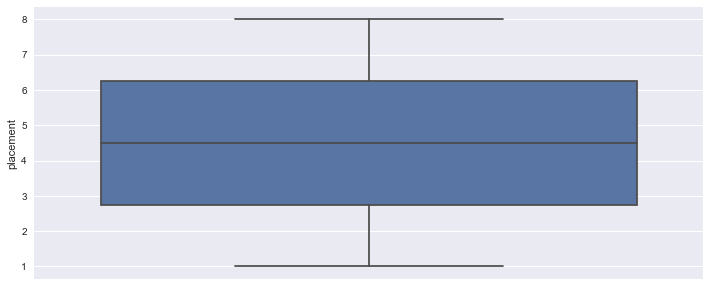

In [70]:
for col in df[['game_length', 'time_eliminated', 'gold_left', 'last_round', 'level', 'placement']]:
    plt.figure(figsize=(12,5))
    sns.boxplot(data=df, y=col);

Some outliers are present but it fits with the context of the game. Lower leveled players have less game time during the match, they were taken out early due to being AFK or taking a risky augment like "Cruel Pact"

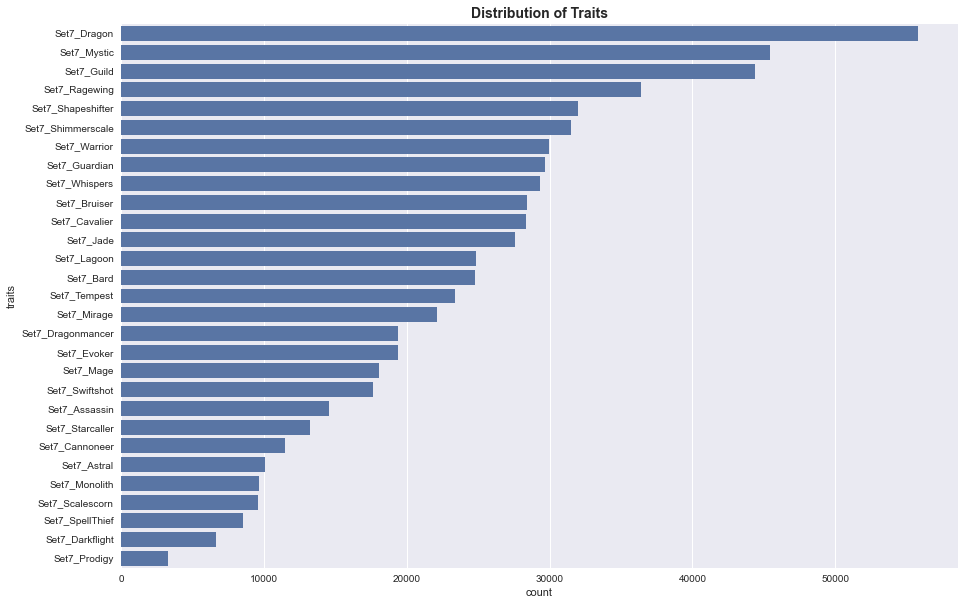

In [36]:
plt.figure(figsize=(15,10))
sns.countplot(y=df.combination.apply(lambda x : list(ast.literal_eval(x).keys())).explode(),
             order = df.combination.apply(lambda x : list(ast.literal_eval(x).keys())).explode().value_counts().index,
             color=sns.color_palette()[0])
plt.ylabel('traits')
plt.title('Distribution of Traits', fontsize=14, weight='bold');

Without surprise, Dragon, Mystic, and Guild were the most dominating traits of set 7. These traits were featured in the TFT Meta Snapshot all the time. Dragons are the main trait of the season, mystic was popular due to most comps using the Bard unit which provides good support to the team. Bard is what we call a "splash unit" a unit that goes with any comp and is useful even if no synergies are provided through traits. And lastly Xayah dominated for almost the entirety of set 7, she is a very powerful 4-cost guild unit.


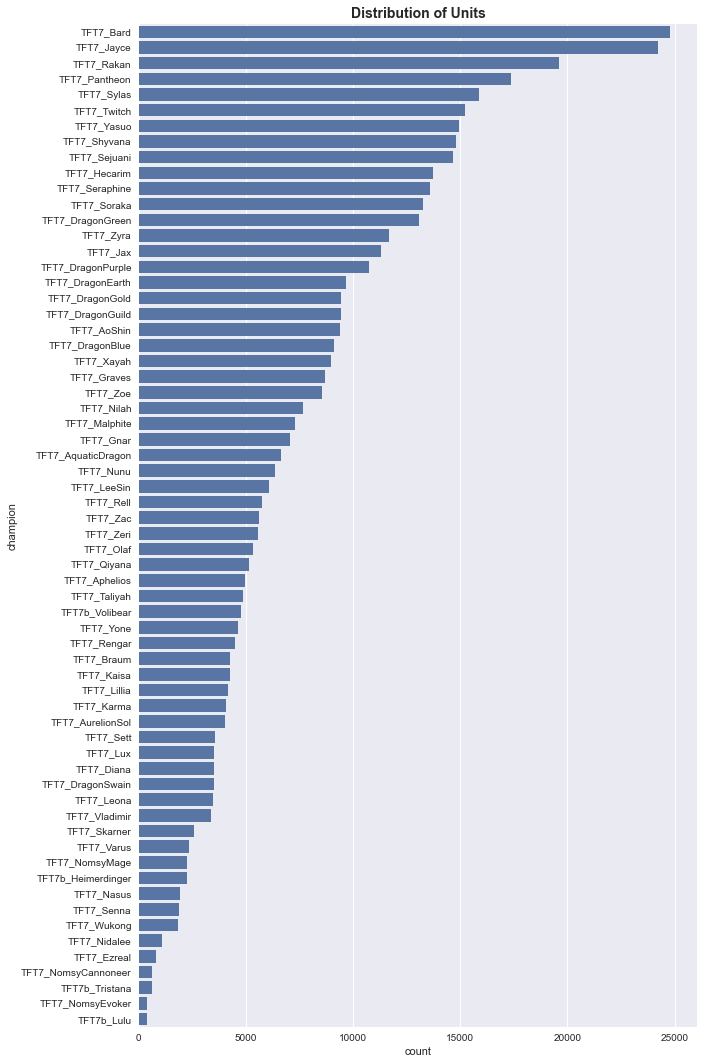

In [37]:
plt.figure(figsize=(10,15))
sns.countplot(y=df.champion.apply(lambda x : list(ast.literal_eval(x).keys())).explode(),
             order = df.champion.apply(lambda x : list(ast.literal_eval(x).keys())).explode().value_counts().index,
             color=sns.color_palette()[0])
plt.title('Distribution of Units', fontsize=14, weight='bold')
plt.tight_layout();

The top 3 units to play are all "splash units" Bard coming in strong for first spot which aligns with previous data. Jayce is a 4-cost guild unit that can be played in any comp, he provides important stats for the whole team. And Rakan is one of the special units this mid set, he is Mystic, Guardian, and Ragewing which is an insane synergy to have for a 3-cost.

What are the common compositions when a player has 2 units? 4 units? 6 units ? 8 or more units?


In [38]:
df['board_count'] = df.apply(lambda x: len(ast.literal_eval(x['champion']).keys()), axis=1)

In [39]:
df.head()

,match_id,game_length,game_version,time_eliminated,gold_left,last_round,level,placement,combination,champion,board_count
0,NA1_4471233617,2353.634277,Version 12.20.474.8882 (Oct 20 2022/13:06:55) ...,1734.635498,0,30,8,7,"{'Set7_Cavalier': 2, 'Set7_Dragon': 2, 'Set7_D...","{'TFT7_Sejuani': {'items': [], 'tier': 1}, 'TF...",6
1,NA1_4471233617,2353.634277,Version 12.20.474.8882 (Oct 20 2022/13:06:55) ...,1732.625000,5,30,8,6,"{'Set7_Bard': 1, 'Set7_Cavalier': 2, 'Set7_Dra...","{'TFT7_Leona': {'items': [], 'tier': 2}, 'TFT7...",6
2,NA1_4471233617,2353.634277,Version 12.20.474.8882 (Oct 20 2022/13:06:55) ...,1512.855347,23,26,7,8,"{'Set7_Astral': 5, 'Set7_Bruiser': 2, 'Set7_Ma...",{'TFT7_Vladimir': {'items': ['TFT_Item_ThiefsG...,7
3,NA1_4471233617,2353.634277,Version 12.20.474.8882 (Oct 20 2022/13:06:55) ...,2345.331299,5,41,9,1,"{'Set7_Bard': 1, 'Set7_Cannoneer': 2, 'Set7_Ev...",{'TFT7_Zyra': {'items': ['TFT_Item_ZekesHerald...,8
4,NA1_4471233617,2353.634277,Version 12.20.474.8882 (Oct 20 2022/13:06:55) ...,2342.827393,20,41,9,3,"{'Set7_Dragon': 1, 'Set7_Dragonmancer': 8, 'Se...","{'TFT7_Sett': {'items': [], 'tier': 3}, 'TFT7_...",8


In [40]:
df.board_count.value_counts()

7     24788
6     20669
8     15385
5      5350
9      2702
4       414
10      107
2        89
1        81
3        79
0        13
11       10
12        1
Name: board_count, dtype: int64

In [41]:
two_units = df[df['board_count'] == 2]
four_units = df[df['board_count'] == 4]
six_units = df[df['board_count'] == 6]
seven_units = df[df['board_count'] == 7]
eight_or_more_units = df[df['board_count'] >= 8]

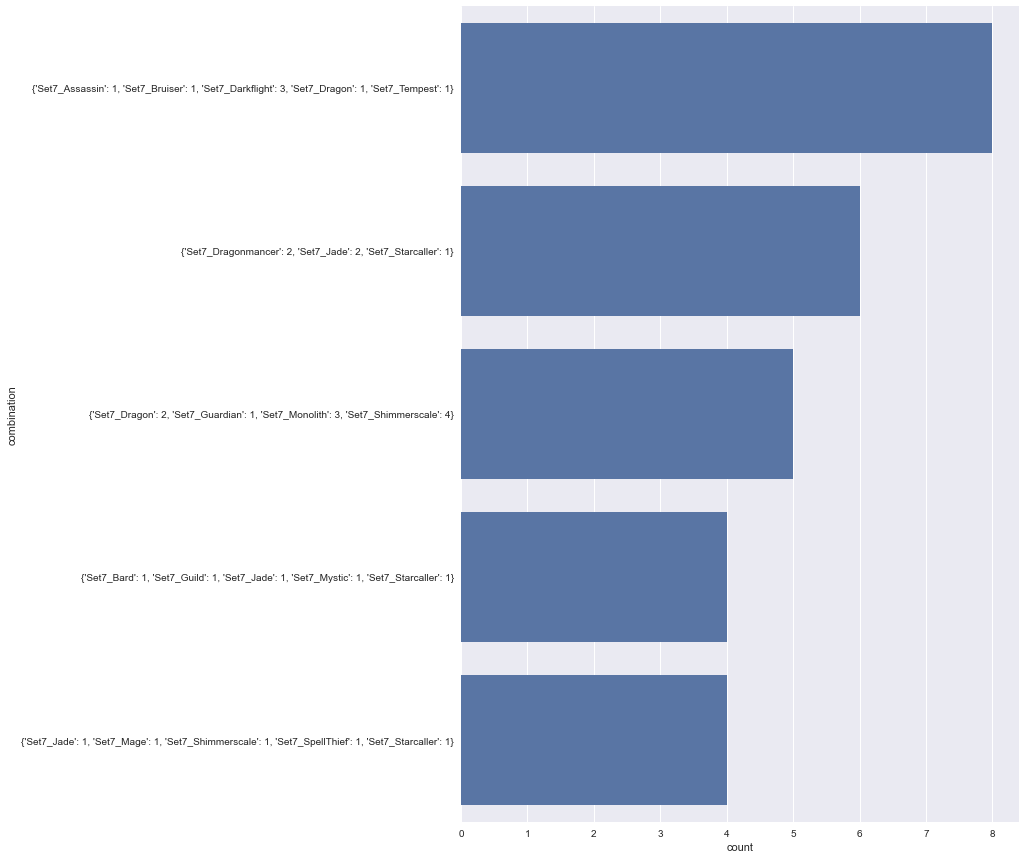

In [42]:
# 2 units
# limit results to top 5
plt.figure(figsize=(10,15))
sns.countplot(y=two_units.combination, order=two_units.combination.value_counts().iloc[:5].index,
              color=sns.color_palette()[0]);

So while  Dragon, Guild, and Mystic were the most common individual traits, individuality alone does not win a TFT game. The best synergies will grant you board strength and this is what these plots are trying to represent.

This plot shows the best synergies when a player has 2 units on the board. Keep in mind that units can have more than one trait! We see the best combinations to have are:

* 1 Assassin, 1 Bruiser, 1 Darkflight, 1 Tempest
* 2 Dragonmancer, 2 Jade, 1 Starcaller
* 2 Dragon, 1 Guardian, 3 Monolith, 4 Shimmerscale

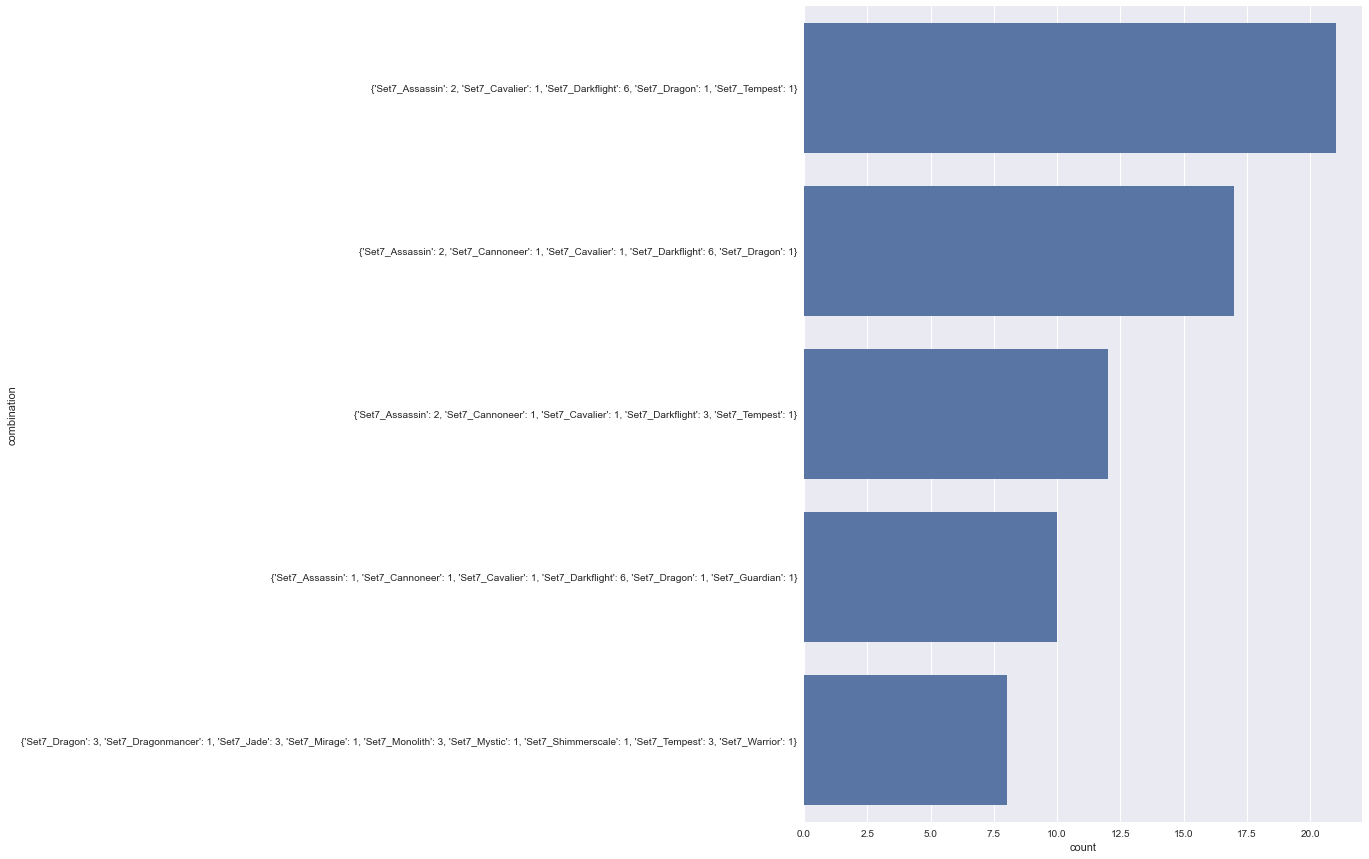

In [43]:
# 4 units
# limit results to top 5
plt.figure(figsize=(10,15))
sns.countplot(y=four_units.combination, order=four_units.combination.value_counts().iloc[:5].index,
              color=sns.color_palette()[0]);

This plot shows the best synergies when a player has 4 units on the board. Keep in mind that units can have more than one trait! We see the best combinations to have are:

* 2 Assassin, 1 Cavalier, 6 Darkflight, 1 Dragon, 1 Tempest
* 2 Assassin, 2 Cannoneer, 1 Cavalier, 6 Darkflight, 1 Dragon
* 2 Assassin, 1 Cannonner, 1 Cavalier, 3 Darkflight, 1 Tempest

Assassin, and darkflight are the most common synergies when having 4 units!

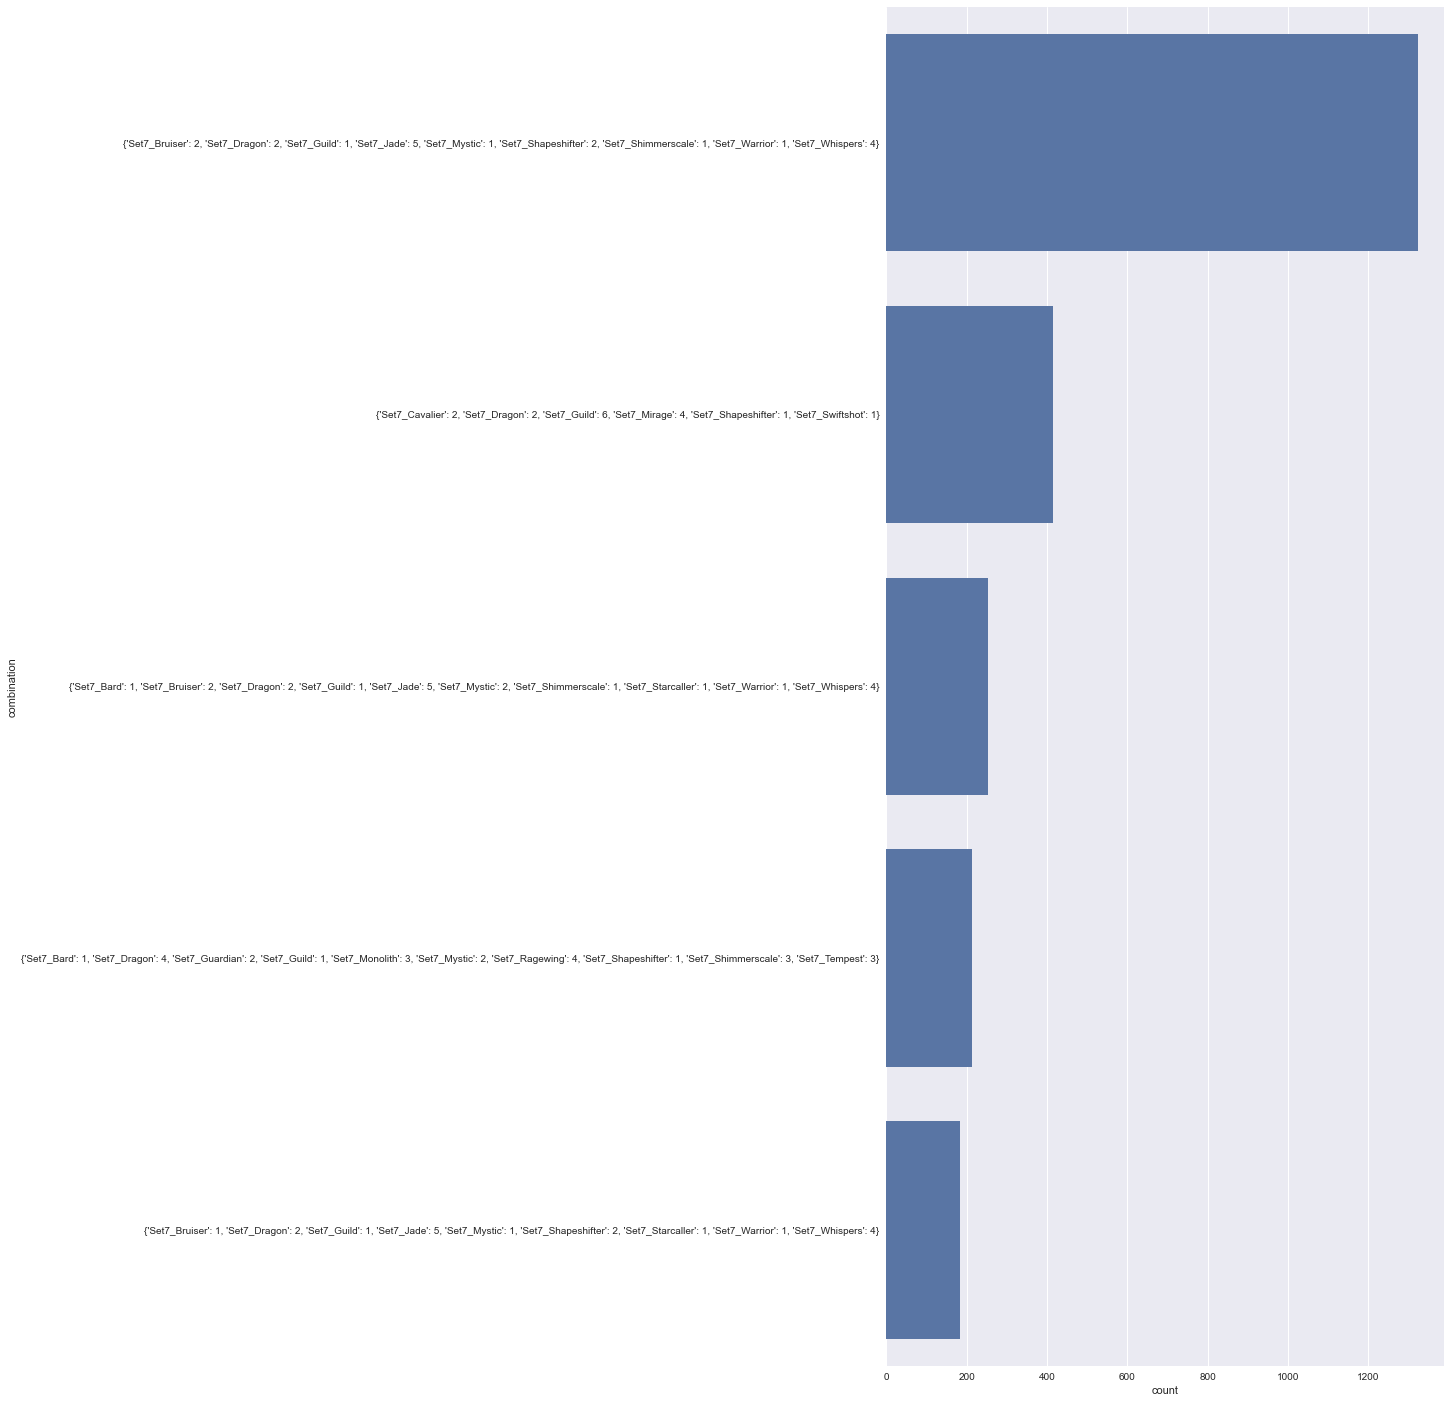

In [44]:
# limit results to top 5 for 6 units
plt.figure(figsize=(10,25))
sns.countplot(y=six_units.combination, order=six_units.combination.value_counts().iloc[:5].index,
              color=sns.color_palette()[0]);

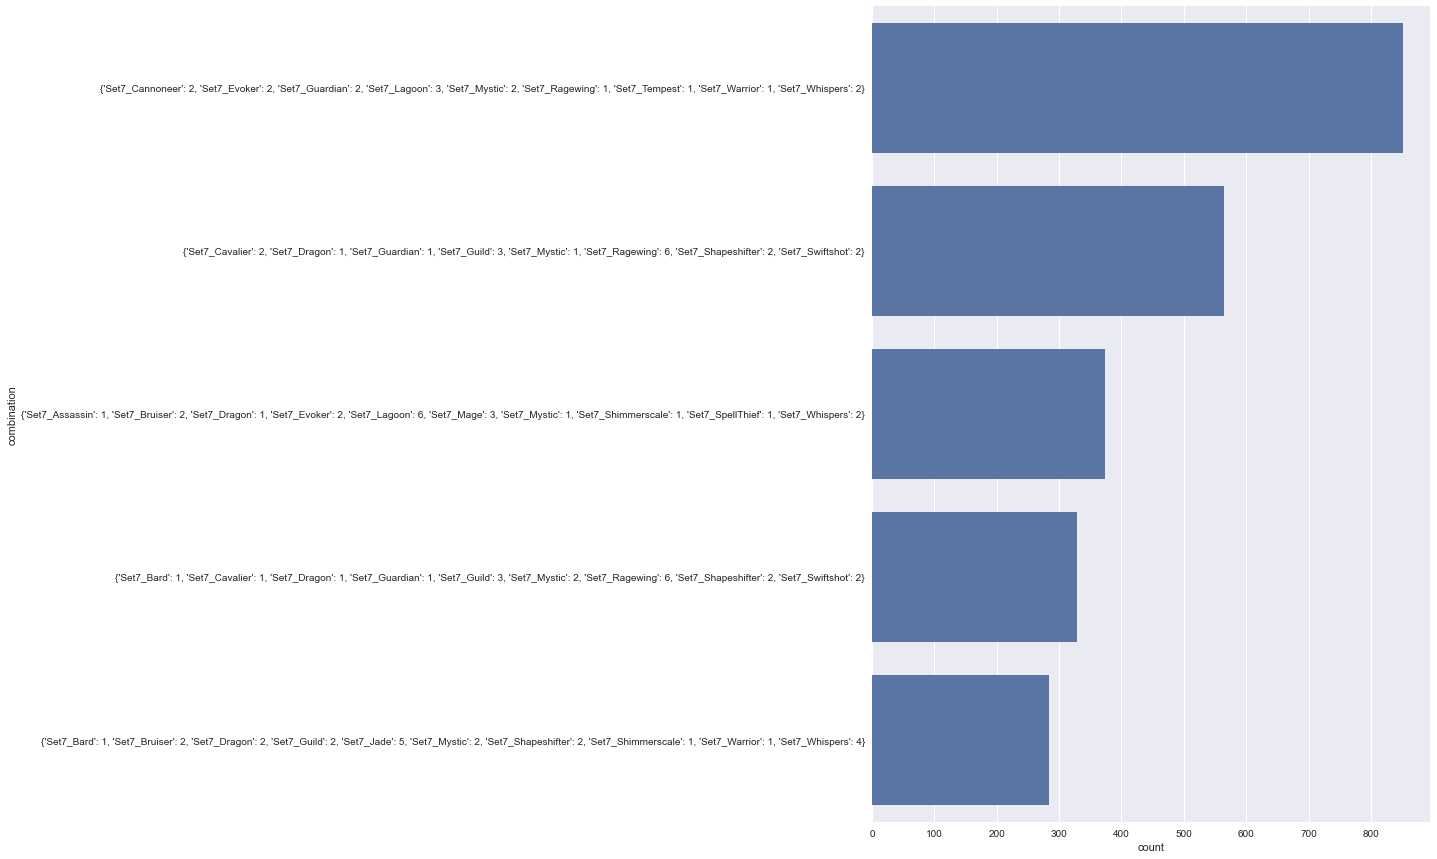

In [45]:
# limit results to top 5 for 7 units
plt.figure(figsize=(10,15))
sns.countplot(y=seven_units.combination, order=seven_units.combination.value_counts().iloc[:5].index,
              color=sns.color_palette()[0]);

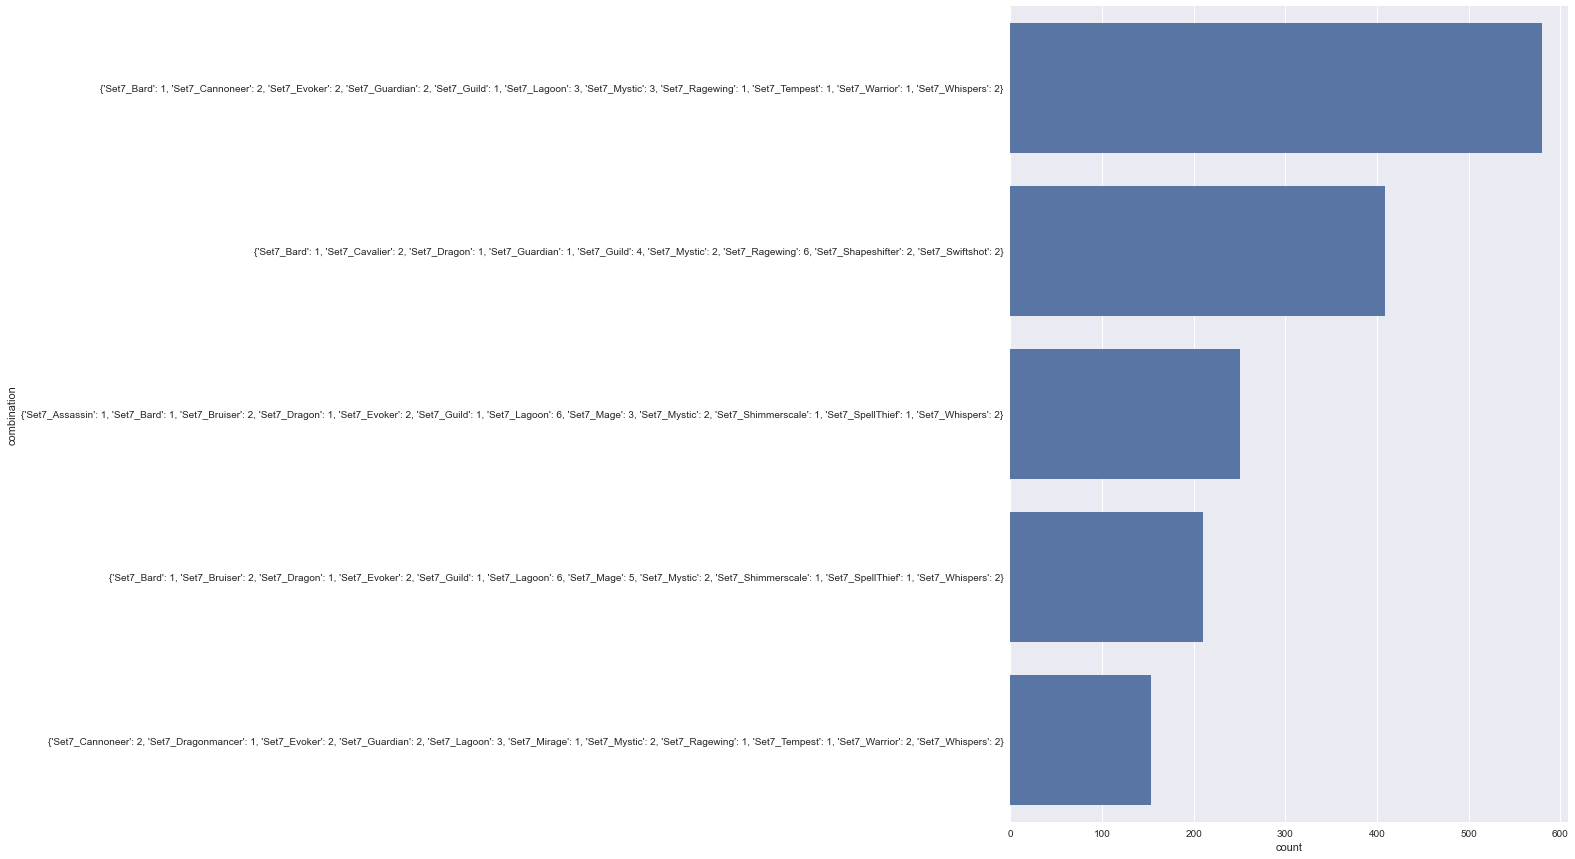

In [46]:
# limit results to top 5 for 8 or more units 
plt.figure(figsize=(10,15))
sns.countplot(y=eight_or_more_units.combination, order=eight_or_more_units.combination.value_counts().iloc[:5].index,
              color=sns.color_palette()[0]);

For a player that has 8 or more units we see that a specific composition is common. 

* 1 Bard, 2 Cannonner, 2 Evoker, 2 Guardian, 1 Guild, 3 Lagoon, 3 Mystic, 1 Ragewing, 1 Tempest, 1 Warrior, 2 Whispers

Does this same composition allow a player to consistently rank up? Which compositions do allow a player to rank up?

One way I can check this is by subsetting the data by placement >= 4. In ranked TFT there is a match making rating system that grants you points or takes them depending on where you score. Landing in 4th place grants you the lowest amounts, 3rd grants you a bit more, 2nd grants you half, and last 1st grants you full points. For ranks 5-8 these are considered losses and the player loses points on the same scale as winning.

In [47]:
ranking_up = df[df['placement'] >= 4 ]
ranking_up.head()

,match_id,game_length,game_version,time_eliminated,gold_left,last_round,level,placement,combination,champion,board_count
0,NA1_4471233617,2353.634277,Version 12.20.474.8882 (Oct 20 2022/13:06:55) ...,1734.635498,0,30,8,7,"{'Set7_Cavalier': 2, 'Set7_Dragon': 2, 'Set7_D...","{'TFT7_Sejuani': {'items': [], 'tier': 1}, 'TF...",6
1,NA1_4471233617,2353.634277,Version 12.20.474.8882 (Oct 20 2022/13:06:55) ...,1732.625000,5,30,8,6,"{'Set7_Bard': 1, 'Set7_Cavalier': 2, 'Set7_Dra...","{'TFT7_Leona': {'items': [], 'tier': 2}, 'TFT7...",6
2,NA1_4471233617,2353.634277,Version 12.20.474.8882 (Oct 20 2022/13:06:55) ...,1512.855347,23,26,7,8,"{'Set7_Astral': 5, 'Set7_Bruiser': 2, 'Set7_Ma...",{'TFT7_Vladimir': {'items': ['TFT_Item_ThiefsG...,7
6,NA1_4471233617,2353.634277,Version 12.20.474.8882 (Oct 20 2022/13:06:55) ...,1826.726074,7,32,8,4,"{'Set7_Bard': 1, 'Set7_Bruiser': 2, 'Set7_Drag...","{'TFT7_Gnar': {'items': [], 'tier': 2}, 'TFT7_...",7
7,NA1_4471233617,2353.634277,Version 12.20.474.8882 (Oct 20 2022/13:06:55) ...,1805.779541,0,31,8,5,"{'Set7_Bard': 1, 'Set7_Cavalier': 1, 'Set7_Dra...",{'TFT7_Twitch': {'items': ['TFT_Item_ChainVest...,6


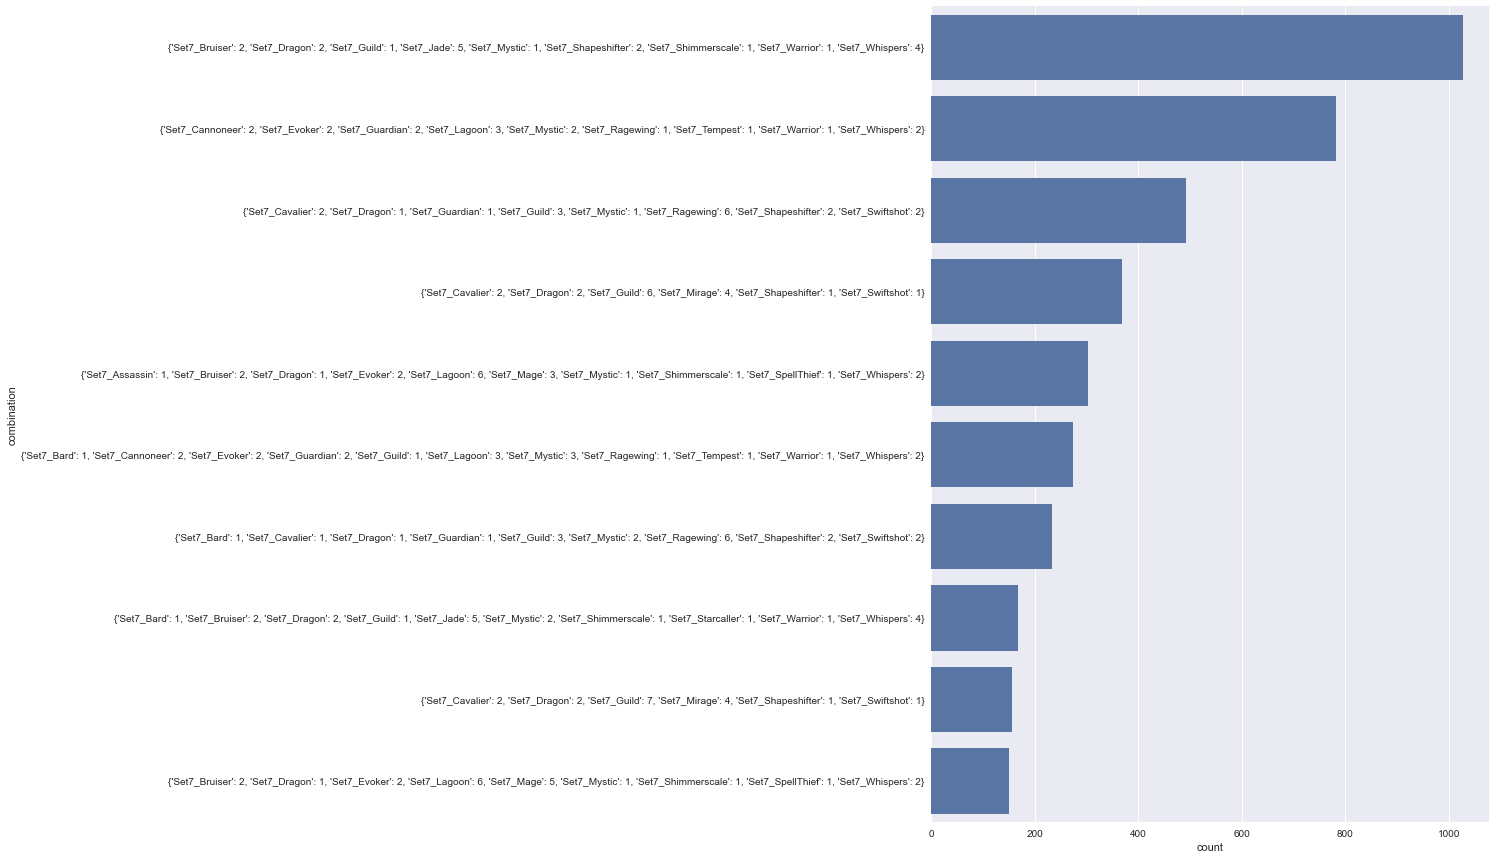

In [48]:
# limit results to top 10 for top 4
plt.figure(figsize=(10,15))
sns.countplot(y=ranking_up.combination, order=ranking_up.combination.value_counts().iloc[:10].index,
              color=sns.color_palette()[0]);

While the composition with the most units is one of the top 10 contenders for ranking up, it is not the best composition to consistently gain match making rating.


* How much gold left does a tactician have when reaching certain levels?

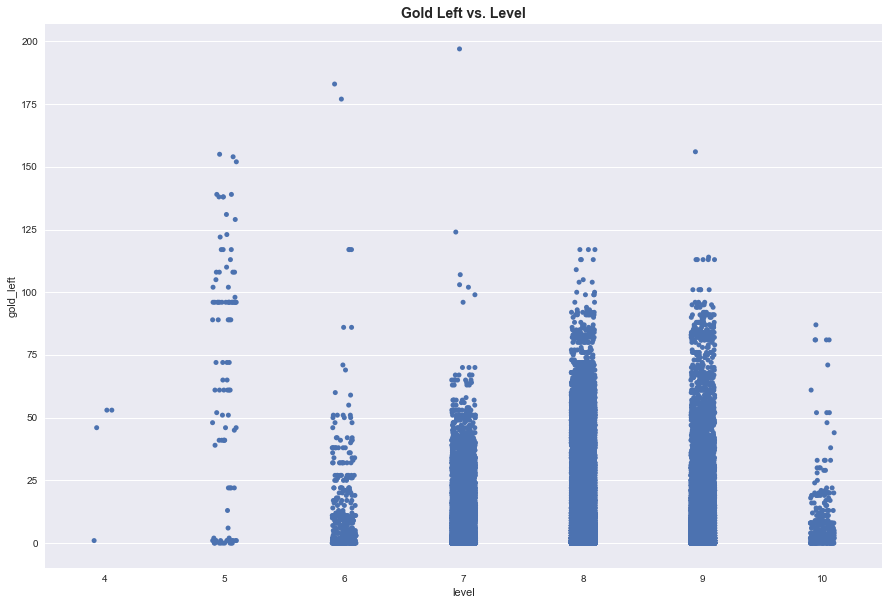

In [51]:
plt.figure(figsize=(15,10))
sns.stripplot(data=df, y='gold_left', x='level', color=sns.color_palette()[0])
plt.title('Gold Left vs. Level', fontsize=14, weight='bold');

Players that hit level 7 have the most gold!? I would like to double check if this is an outlier.


In [50]:
df[(df.level == 7) & (df.gold_left > 175)]

,match_id,game_length,game_version,time_eliminated,gold_left,last_round,level,placement,combination,champion,board_count
52598,NA1_4452251180,2295.654541,Version 12.18.468.3251 (Sep 16 2022/13:11:56) ...,2287.477539,197,37,7,2,"{'Set7_Astral': 3, 'Set7_Bruiser': 2, 'Set7_Ca...","{'TFT7_Skarner': {'items': [], 'tier': 2}, 'TF...",7


Checks out! This must of been a high-streaking player, players that win 5 or more matches gain extra gold for each win-streak stack (max 5).